In [2]:
import utils_general
import utils_coup
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import expm
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 2: Coupled 3 box model
## a) Forcing applied evenly into all boxes

### $\frac{\partial}{\partial t} C_i = -L_{i,j} C_i + F(t)$

### Integrated solutions to experiments of interest

In [5]:
np.shape(T_ODE['2xCO2'])

(3, 400)

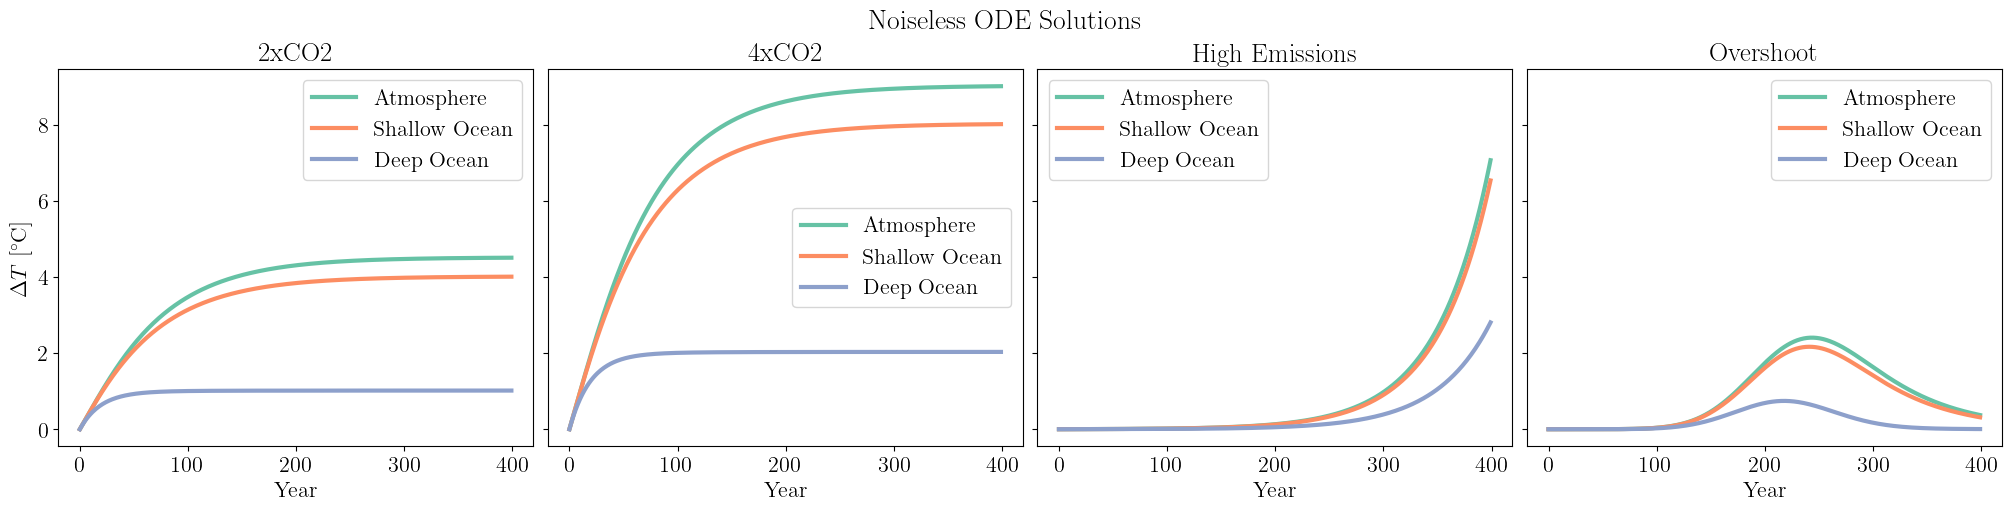

In [3]:
T_ODE, g_ODE, a_ODE = utils_coup.create_coup(noisy=False)

#### Method 1: Direct derivation of Green's function

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Emissions: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0

Error from Modal estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Emissions: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



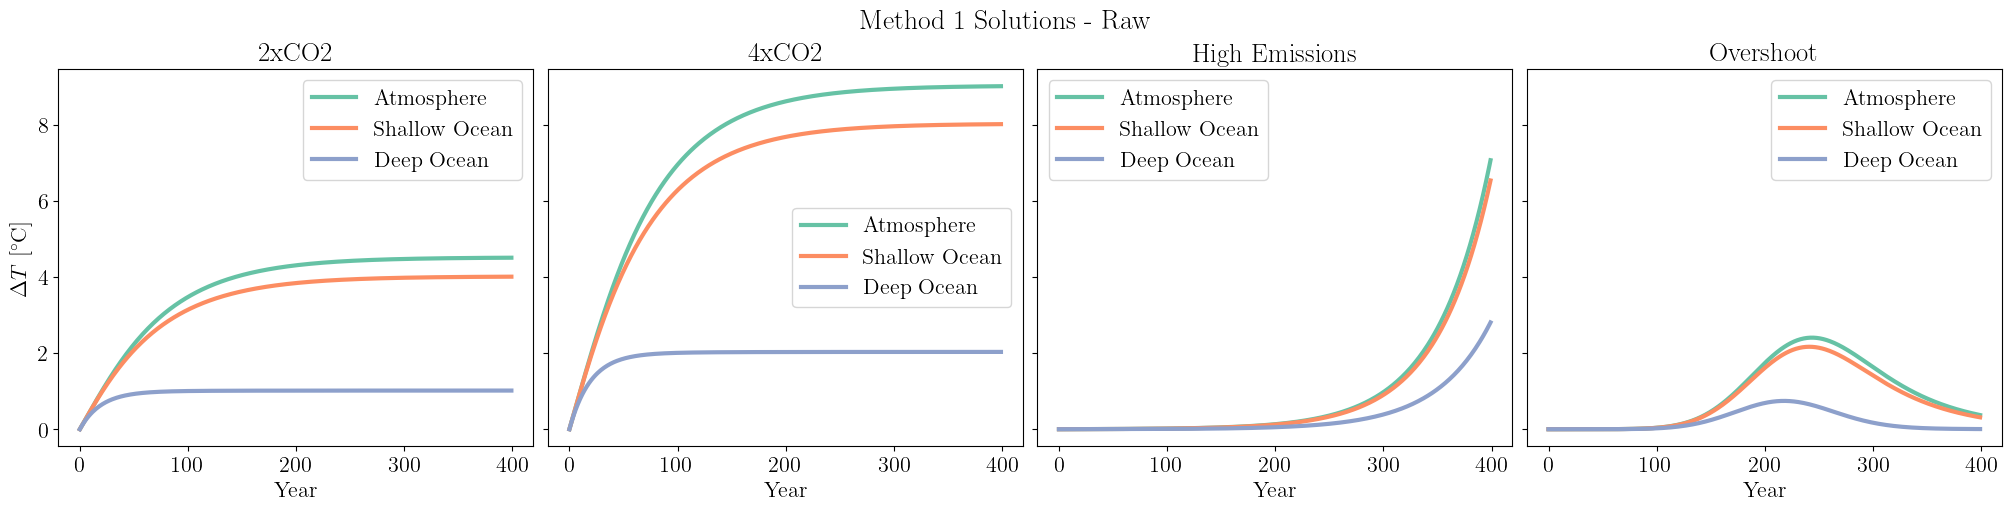

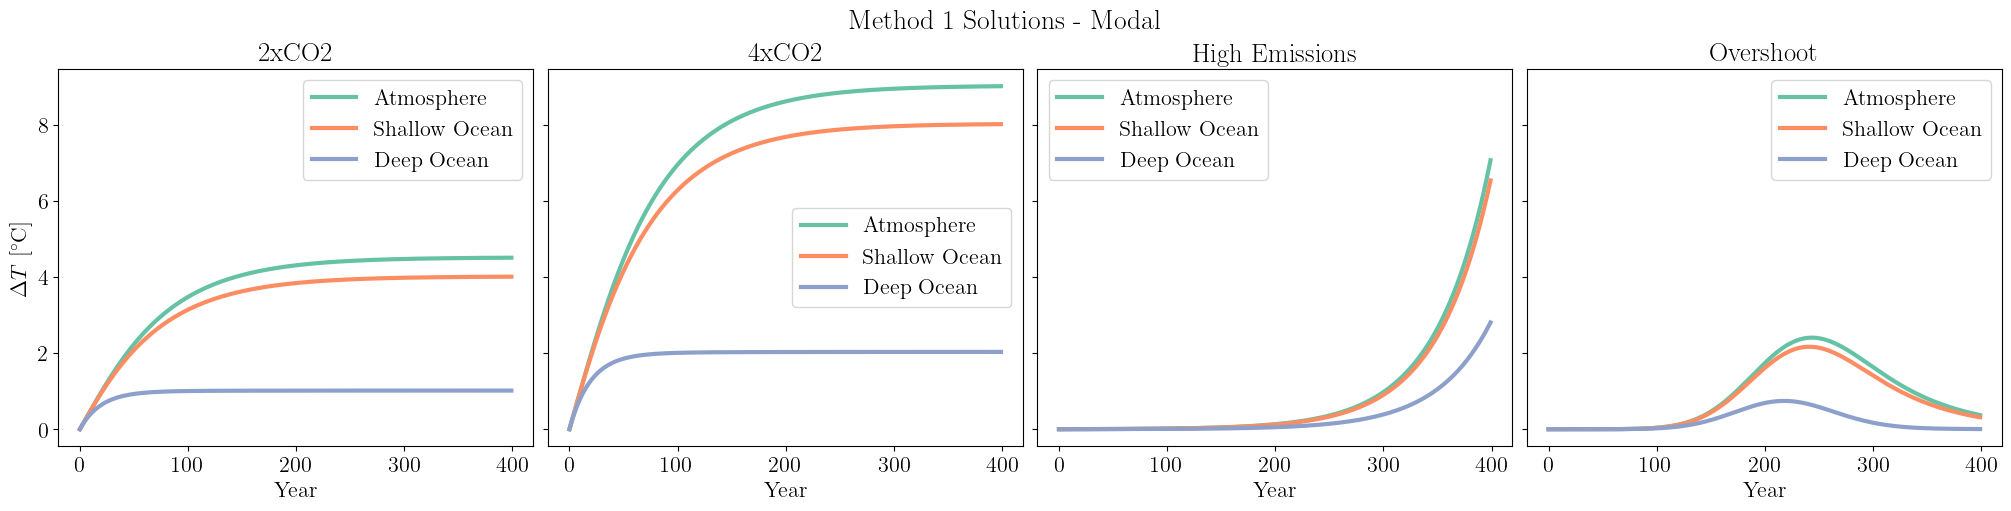

In [208]:
T_raw_method_1, T_modal_method_1, G_raw_method_1, G_modal_method_1 = utils_coup.method_1_direct(T_ODE, modal=True)

#### Method 2: Direct inference of L from a dataset

Error from Raw estimation.
	L2 Error, 2xCO2: 0.19398
	L2 Error, 4xCO2: 0.38796
	L2 Error, High Emissions: 0.3112
	L2 Error, Overshoot: 0.15712
Avg. L2 Error: 0.26256

Error from Modal estimation.
	L2 Error, 2xCO2: 0.19398
	L2 Error, 4xCO2: 0.38796
	L2 Error, High Emissions: 0.3112
	L2 Error, Overshoot: 0.15712
Avg. L2 Error: 0.26256



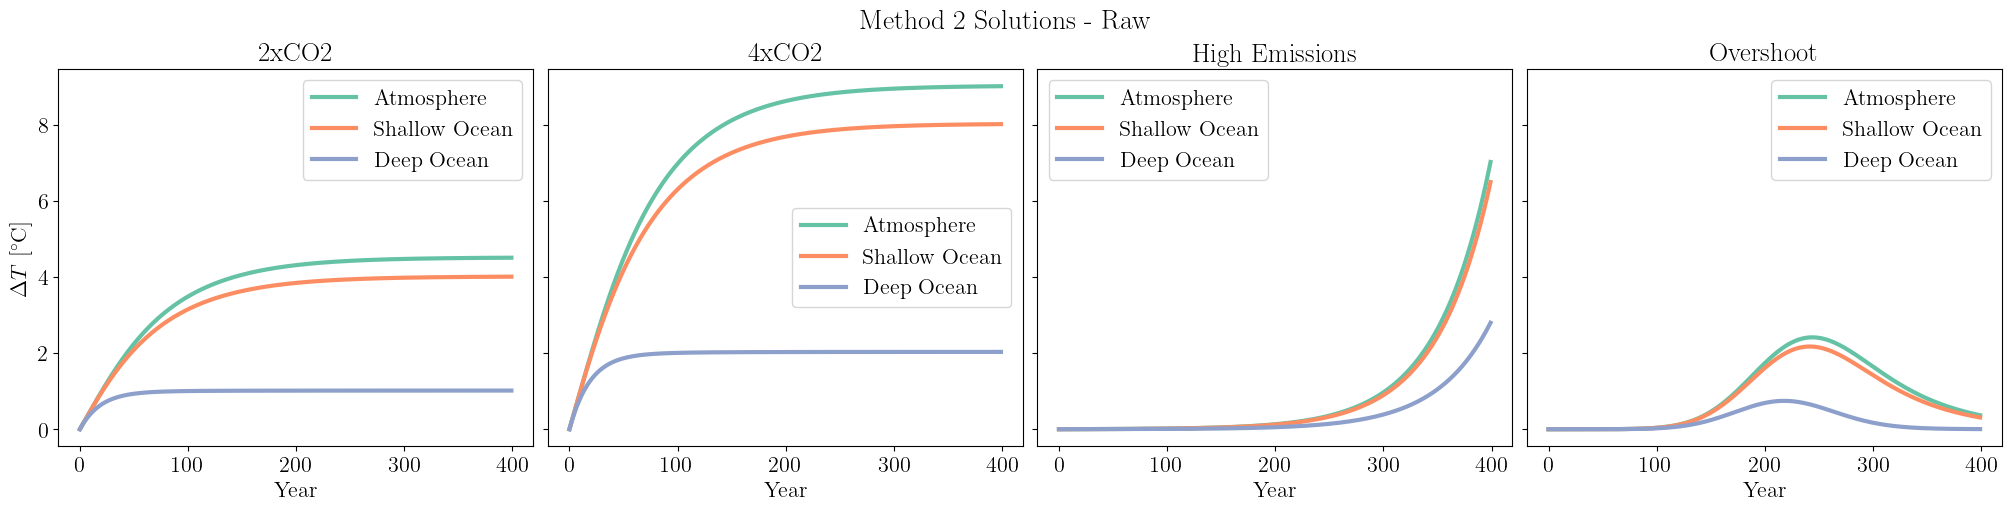

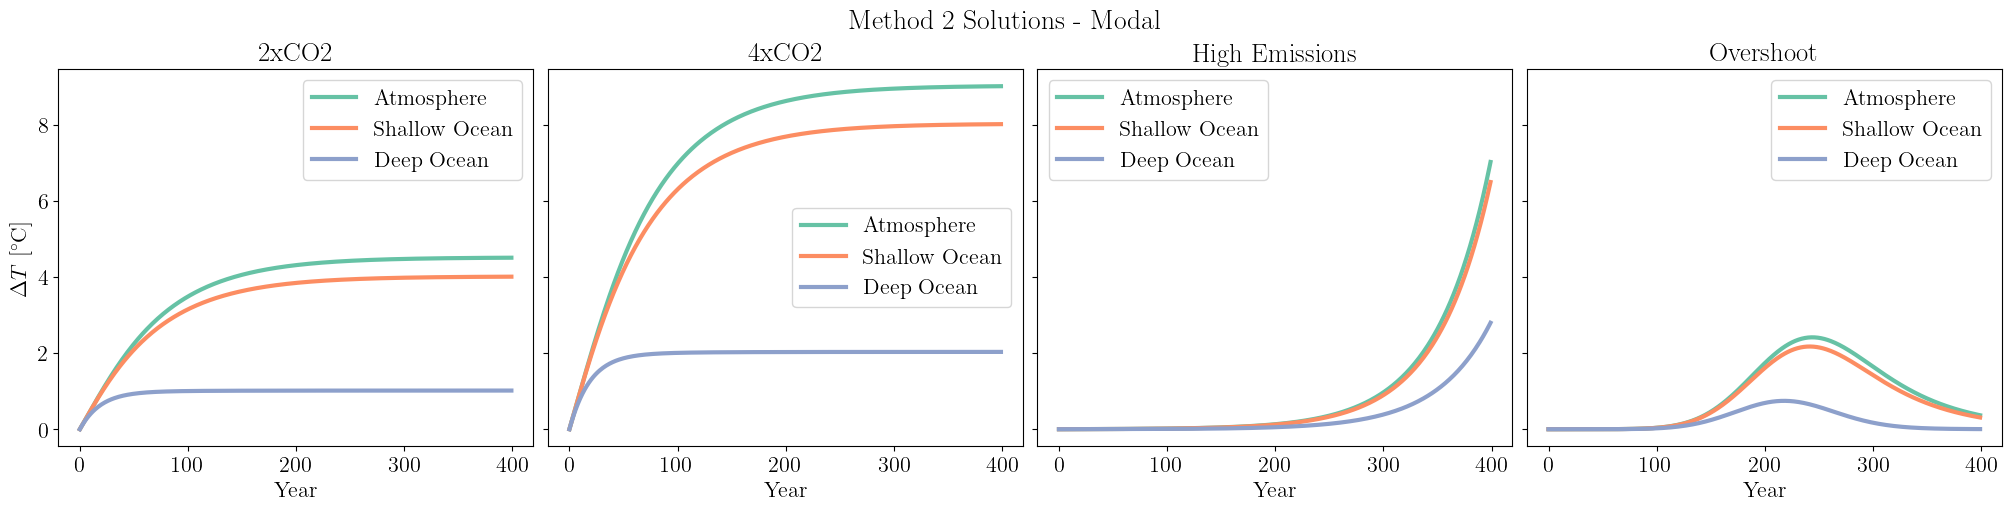

In [255]:
T_raw_method_2, T_modal_method_2, L_raw_method_2, L_modal_method_2 = utils_coup.method_2_L(T_ODE, g_ODE, a_ODE, modal=True)

#### Method 3: Direct deconvolution of response function from dataset

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Emissions: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0

Error from Modal estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Emissions: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



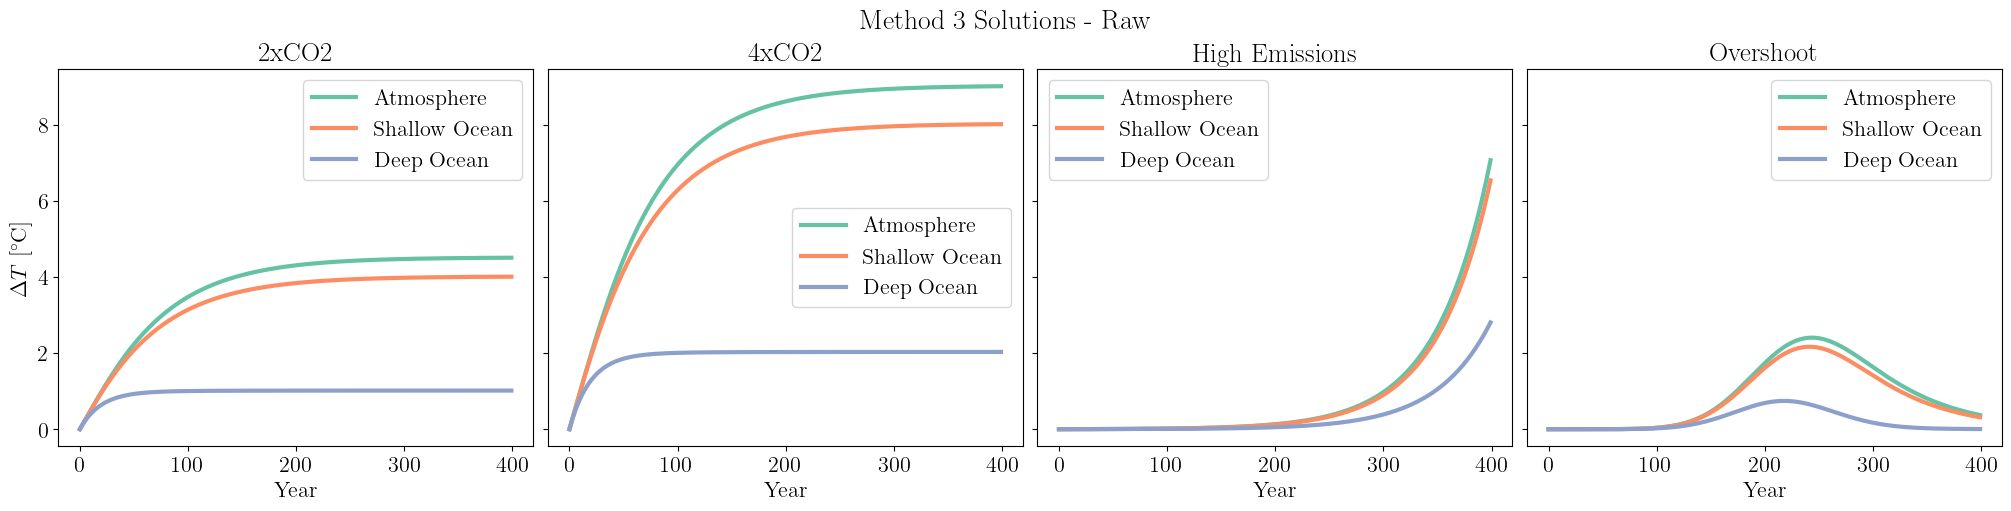

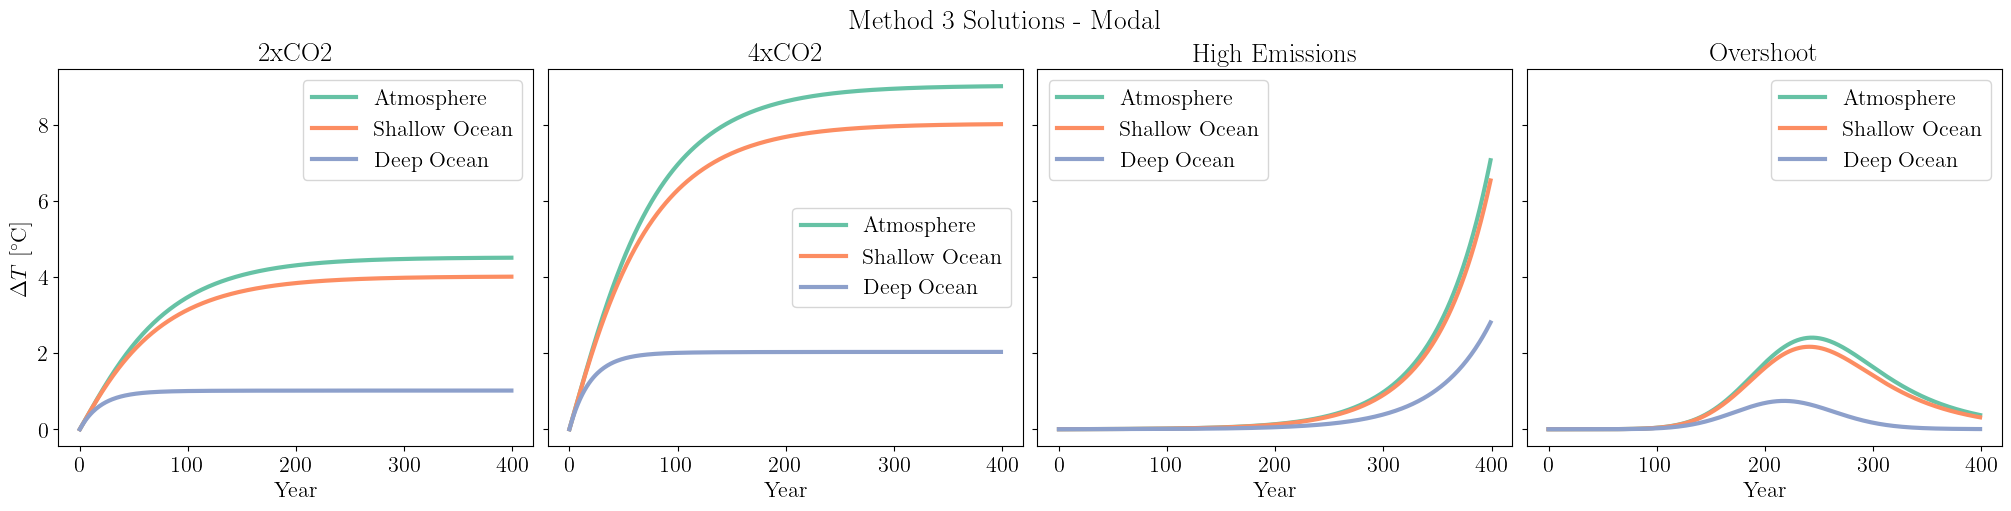

In [78]:
T_raw_method_3, T_modal_method_3, G_raw_method_3, G_modal_method_3 = utils_coup.method_3_deconv(T_ODE, g_ODE, a_ODE, modal=True)

#### Method 4: Estimation of response function using only leading timescales

##### a) Single leading order timescale

Error from Raw estimation.
	L2 Error, 2xCO2: 4.46014
	L2 Error, 4xCO2: 8.92028
	L2 Error, High Emissions: 0.00432
	L2 Error, Overshoot: 3.50407
Avg. L2 Error: 4.2222

Error from Modal estimation.
	L2 Error, 2xCO2: 4.46014
	L2 Error, 4xCO2: 8.92028
	L2 Error, High Emissions: 0.00432
	L2 Error, Overshoot: 3.50407
Avg. L2 Error: 4.2222



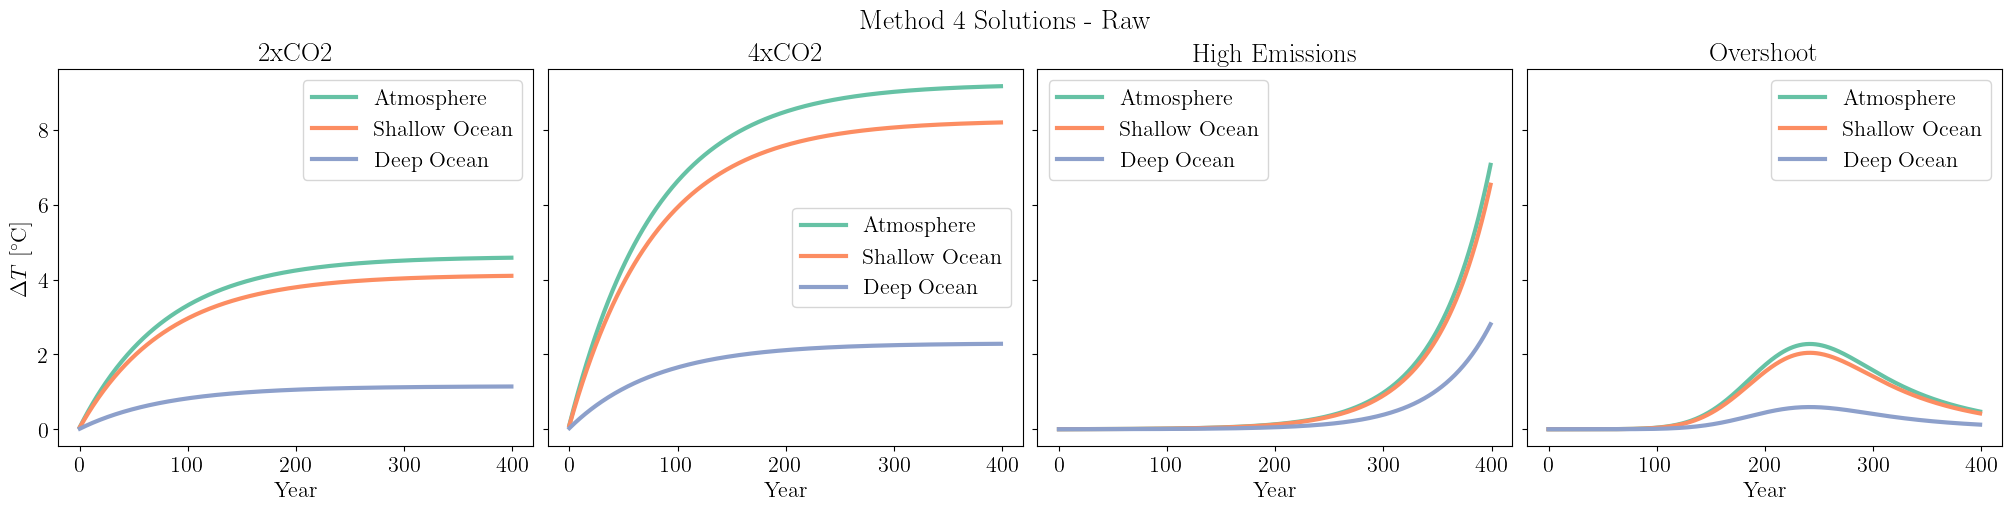

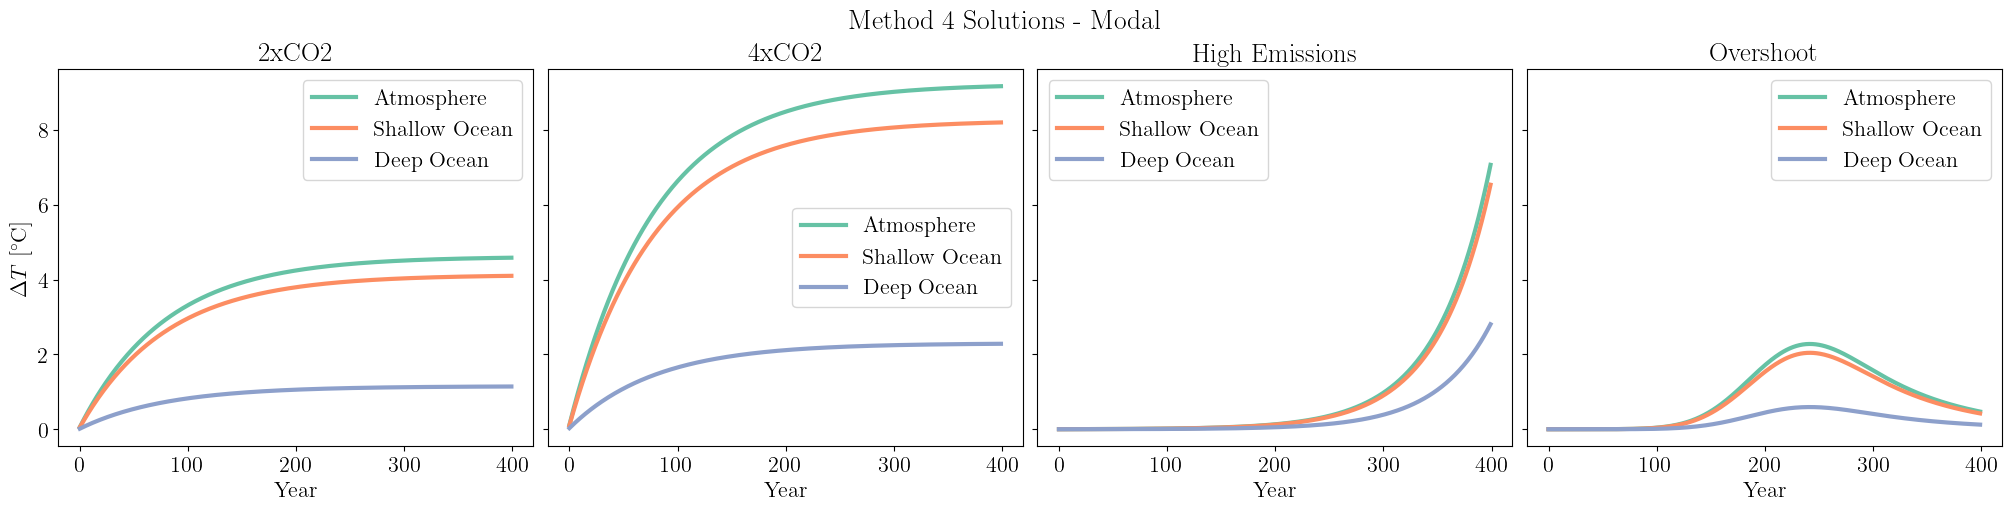

In [267]:
m, k = 1, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit(T_ODE, g_ODE, a_ODE, m, k, modal=True)

##### a.ii) Two leading order timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 0.46528
	L2 Error, 4xCO2: 8.9364
	L2 Error, High Emissions: 0.00556
	L2 Error, Overshoot: 0.33309
Avg. L2 Error: 2.43508

Error from Modal estimation.
	L2 Error, 2xCO2: 0.46528
	L2 Error, 4xCO2: 8.93641
	L2 Error, High Emissions: 0.00512
	L2 Error, Overshoot: 0.33309
Avg. L2 Error: 2.43497



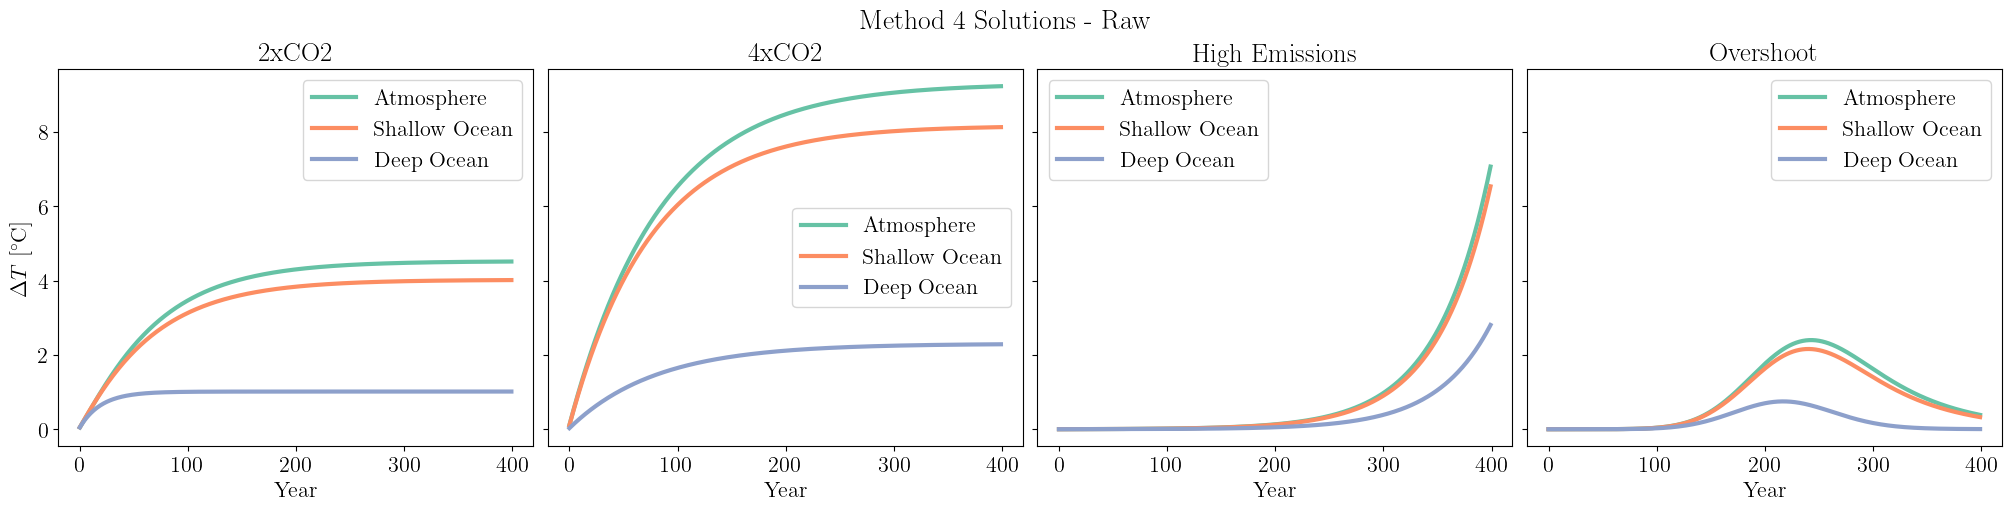

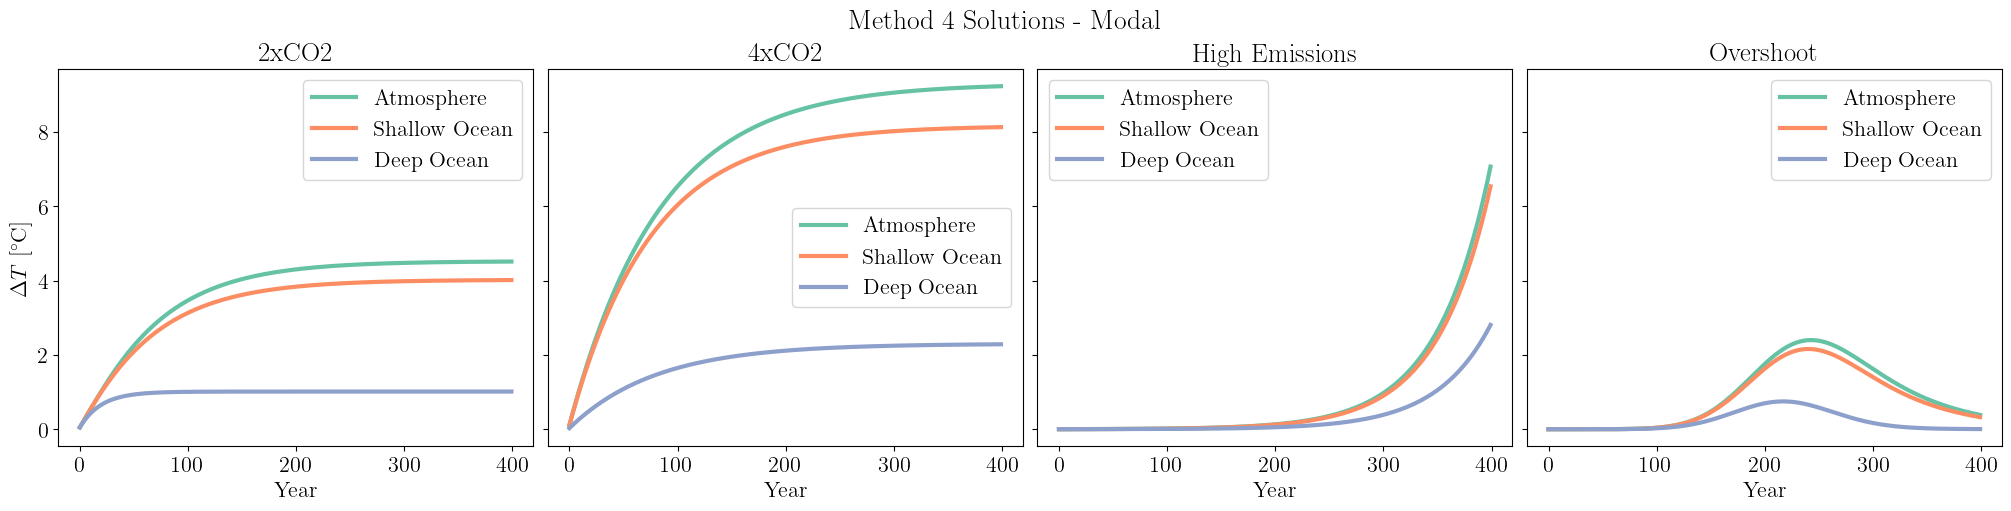

In [261]:
m, k = 2, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit(T_ODE, g_ODE, a_ODE, m, k, modal=True)

##### a.iii) All timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 0.37026
	L2 Error, 4xCO2: 0.79789
	L2 Error, High Emissions: 5.01517
	L2 Error, Overshoot: 0.19301
Avg. L2 Error: 1.59408

Error from Modal estimation.
	L2 Error, 2xCO2: 0.41166
	L2 Error, 4xCO2: 0.44541
	L2 Error, High Emissions: 5.01518
	L2 Error, Overshoot: 0.07859
Avg. L2 Error: 1.48771



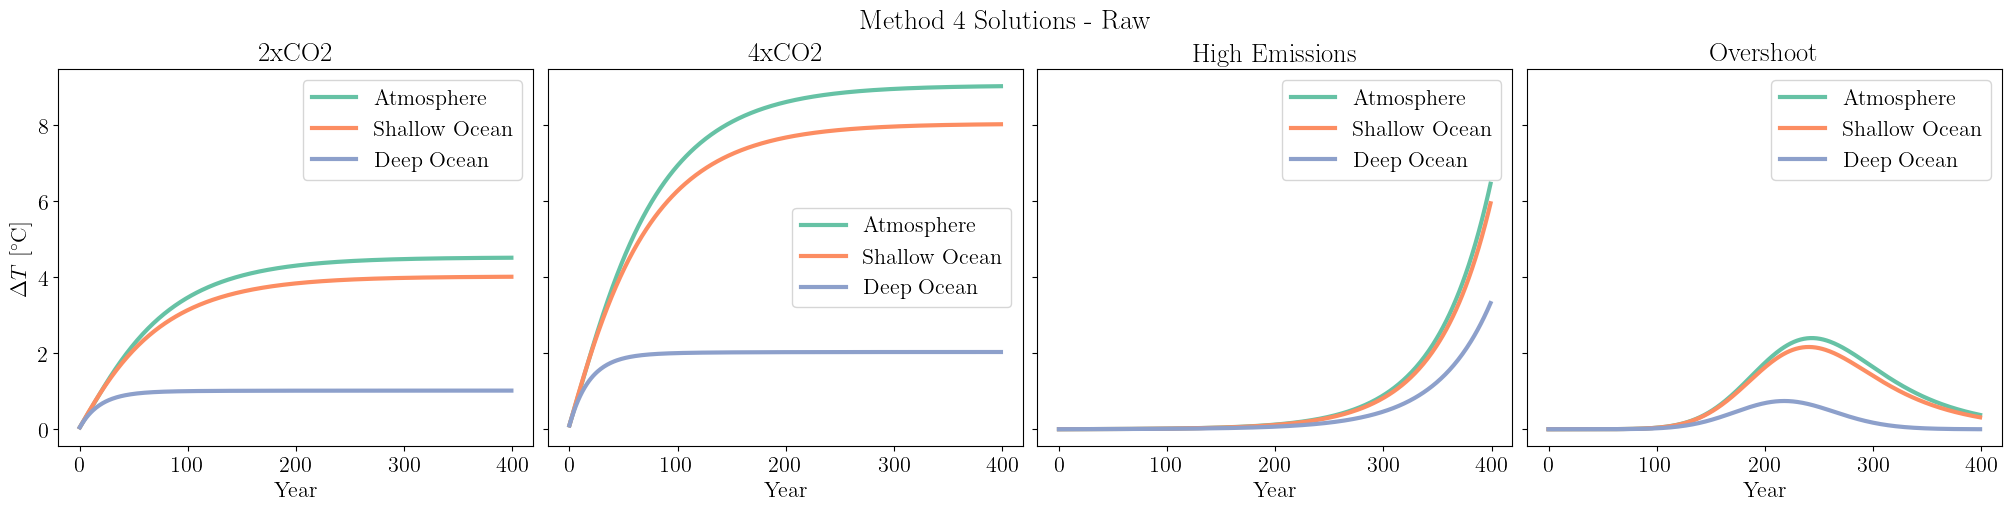

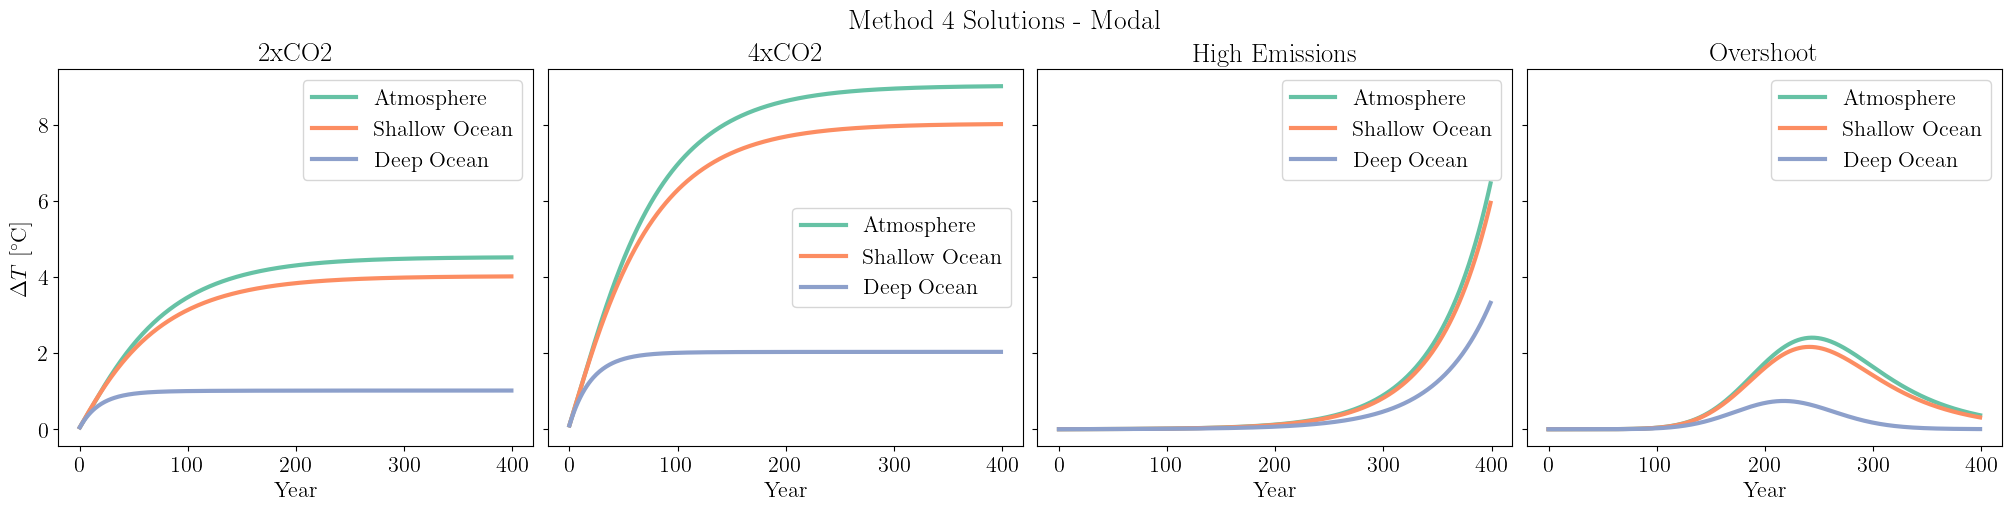

In [262]:
m, k = 3, 3
T_raw_method_4, T_modal_method_4, G_raw_method_4, G_modal_method_4 = utils_coup.method_4_fit(T_ODE, g_ODE, a_ODE, m, k, modal=True)